# Анализ данных на Python

*Алла Тамбовцева*

## Практикум по иерархическому кластерному анализу (количественные данные)

В этом практикуме мы будем работать с данными по районам Балтимора из файла `Baltimore_data.csv`. В этом файле собраны показатели, которые можно считать характеристиками благополучия района, в том числе с точки зрения покупки в этом районе жилья:

* `CSA2010`: название укрупненного района, по которому ведётся сбор статистических данных (*Community Statistical Area*), в соответствии с делением в 2010 году;
* `trees17`: процент деревьев в районе по состоянию на 2017 год (подробнее [здесь](https://data.baltimorecity.gov/maps/e8b7beca0fd649b1a77c58fafc4658a9/about));
* `racdiv21`: индекс расового/этнического разнообразия за 2021 год, более высокие значения – более высокое разнообразие (подробнее [здесь](https://data.baltimorecity.gov/maps/d588f7de06cf4815951e105bb8a390b1/about));
* `viol21`: число тяжких преступлений на 1000 жителей в 2021 году, включает число убийств, изнасилований, нападения, грабежи (подробнее [здесь](https://data.baltimorecity.gov/maps/ab03385abf3b4f50aec0b090caa8877a/about));
* `salepr19`: медианная цена продажи жилья в районе за 2019 год.

Глобальные задачи:

* поделить районы на группы с помощью иерархического кластерного анализа;
* посмотреть, связано ли деление на группы с географическим расположением районов.

### Часть 1: загрузка данных и разведывательный анализ

Импортируем необходимые библиотеки:

In [1]:
import warnings

import pandas as pd
import numpy as np

# выключаем предупреждения
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

Загрузим данные из CSV-файла: 

In [2]:
df = pd.read_csv("Baltimore_data.csv")
df.head()

,Unnamed: 0,CSA2010,trees17,racdiv21,viol21,salepr19
0,0,Allendale/Irvington/S. Hilton,32.372913,24.604789,17.264634,77250.0
1,1,Beechfield/Ten Hills/West Hills,48.696974,52.412494,11.007200,149000.0
2,2,Belair-Edison,20.827125,23.826836,16.837918,89758.0
3,3,Brooklyn/Curtis Bay/Hawkins Point,14.631858,80.860745,18.028044,57000.0
4,4,Canton,12.516619,40.504514,6.796941,275000.0


Уберём лишний столбец *Unnamed: 0*:

In [3]:
df = df.drop(columns = ["Unnamed: 0"])
df.head()

,CSA2010,trees17,racdiv21,viol21,salepr19
0,Allendale/Irvington/S. Hilton,32.372913,24.604789,17.264634,77250.0
1,Beechfield/Ten Hills/West Hills,48.696974,52.412494,11.007200,149000.0
2,Belair-Edison,20.827125,23.826836,16.837918,89758.0
3,Brooklyn/Curtis Bay/Hawkins Point,14.631858,80.860745,18.028044,57000.0
4,Canton,12.516619,40.504514,6.796941,275000.0


Выведем описательные статистики для всех столбцов датафрейма:

In [4]:
df.describe()

,trees17,racdiv21,viol21,salepr19
count,55.000000,55.000000,55.000000,55.000000
mean,25.752190,42.114051,17.688052,150929.427273
std,16.575468,21.000741,10.369799,77901.761620
min,4.147014,5.799200,2.059591,48000.000000
25%,12.583984,24.400640,10.835260,90379.000000
50%,22.420100,43.415502,16.584042,141500.000000
75%,32.429193,57.856781,22.826308,199700.000000
max,72.916314,80.906662,53.767993,367250.000000


Построим гистограммы для всех числовых показателей, чтобы понять, можно ли уже на этом этапе, рассматривая переменные по отдельности, выделить какие-то группы и сделать предположения о том, сколько кластеров будет логично ожидать. Начнем с процента деревьев в районе:

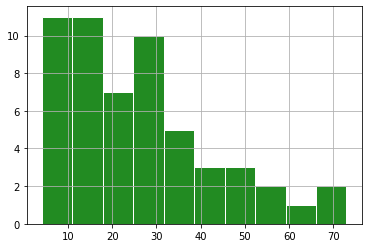

In [6]:
df["trees17"].hist(color = "forestgreen", edgecolor = "white");

Глядя на распределение процента деревьев в районе, нельзя сказать, что есть явные отличающиеся друг от друга группы наблюдений – если бы они были, мы бы увидели несколько выраженных пиков (мультимодальное распределение) или группы столбцов с пустыми «зазорами» между ними. Тем не менее, распределение скошено вправо, очень зелёные районы с процентом деревьев выше 50 – редкость, а, значит, такие районы могут быть выделены в отдельную небольшую группу.

Посмотрим на расовое/этническое разнообразие:

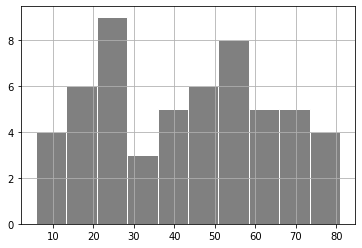

In [7]:
df["racdiv21"].hist(color = "grey", edgecolor = "white");

Распределение бимодальное, тут два пика, один в окрестности значения 25%, другой – в окрестности 55%. По этому показателю логично делить наблюдения на две группы: районы с довольно высокой этнической однородностью и районы с относительно высоким этническим разнообразием.

Изучим преступность:

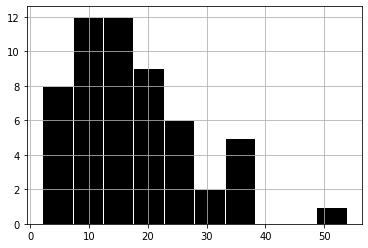

In [8]:
df["viol21"].hist(color = "black", edgecolor = "white");

Тут интересная история. С одной стороны, есть районы с низкой преступностью (10-15 преступлений на 1000 жителей) и более высокой преступностью (30-35 преступлений на 1000 жителей). С другой стороны, есть какой-то район с запредельным, по сравнению с остальными, уровнем преступности. Кто бы это мог быть?

In [9]:
### выясним
df[df["viol21"] > 40]

,CSA2010,trees17,racdiv21,viol21,salepr19
13,Downtown/Seton Hill,7.357698,69.440891,53.767993,199500.0


Даунтаун! Центральный район, в котором расположено много бизнес-центров, офисов, а также развлекательных заведений вроде баров и ночных клубов, популярный у туристов – высокий уровень преступности вполне можно объяснить. Не исключено, что на каком-то этапе иерархического кластерного анализа этот район будет выделен в отдельный монокластер (необязательно, но если он и по другим показателям будет сильно отличаться от других – шансы этого увеличатся).

Осталось изучить цены на жильё:

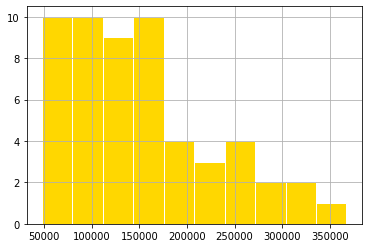

In [10]:
df["salepr19"].hist(color = "gold", edgecolor = "white");

С числом пиков здесь сложновато, но на участке от 50 тысяч долларов до 175 тысяч долларов распределение медианной цены на жилье вполне равномерное, а вот на участке выше 175 тысяч долларов оно другое, более колокообразное, хотя и не нормальное.

Теперь попробуем рассмотреть совместное распределение. Построим диаграмму рассеивания между преступностью и медианной стоимостью жилья:

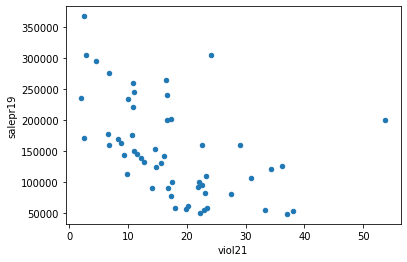

In [11]:
df.plot.scatter(x = "viol21", y = "salepr19");

Районы с более низким уровнем преступности – более дорогие, это логично. При этом Даунтаун и здесь выделяется: медианная стоимость жилья далеко не самая низкая, а уровень преступности очень высокий.

Теперь давайте построим диаграмму рассеивания с дополнительными переменными – третьим измерением в виде цвета:

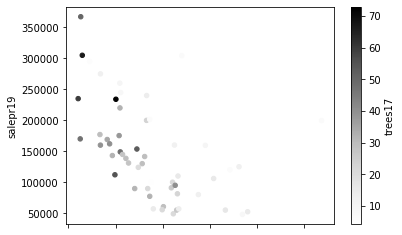

In [7]:
# аргумент c – color
# свою цветовую палитру для градиента пока не добавляем

df.plot.scatter(x = "viol21", y = "salepr19", c = "trees17");

Что тут видно? Что районы с низким уровнем преступности и высокой стоимостью жилья к тому же самые зелёные – точки темного цвета соответствуют проценту деревьев выше 45.

С таким же успехом в качестве третьего измерения можно добавить и индекс расового/этнического разнообразия:

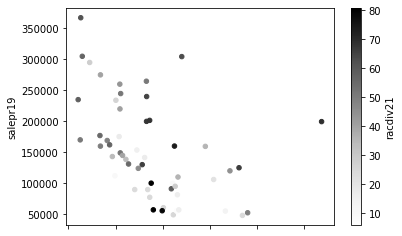

In [13]:
df.plot.scatter(x = "viol21", y = "salepr19", c = "racdiv21");

Тут однозначно сложно что-то сказать, точки разных цветов «перемешаны» на графике.

**Дополнительно.** Кому интересно –  про трёхмерные диаграммы рассеивания можно почитать [здесь](https://stackabuse.com/seaborn-scatter-plot-tutorial-and-examples/).

### Часть 2: иерархический кластерный анализ

Итак, мы выяснили, что на этапе разведывательного анализа данных выделить какие-то явные группы районов нам не удалось. Однако мы точно видели, что основания для деления есть, как минимум, понятно, что:

* есть районы с высокой преступностью и одновременно более низкой стоимостью жилья, 
* есть достаточно благополучные дорогие районы, при этом они могут быть более зелёными (возможно, окраины города с парками) и менее зелёными (возможно, центральные районы с плотной застройкой, но не такие неоднозначные как Даунтаун).

Перейдём к кластерному анализу. Для начала выберем только числовые столбцы – текстовые будут нам мешать, поскольку данные нужно будет стандартизировать, а затем считать по ним расстояния. Если бы они были нужны, мы бы их перекодировали, но это отдельная история, мы пока работаем только с количественными данными. 

In [8]:
to_clust = df.select_dtypes(include = float)
to_clust.head()

,trees17,racdiv21,viol21,salepr19
0,32.372913,24.604789,17.264634,77250.0
1,48.696974,52.412494,11.007200,149000.0
2,20.827125,23.826836,16.837918,89758.0
3,14.631858,80.860745,18.028044,57000.0
4,12.516619,40.504514,6.796941,275000.0


Текстовый столбец с названием районов мы убрали, но саму информацию о том, где какой район, хотелось бы сохранить, иначе не совсем понятно, как в дальнейшем интерпретировать результаты кластеризации. 

Добавим текстовые метки в качестве названий строк:

In [9]:
to_clust.index = df["CSA2010"]
to_clust.head()

,trees17,racdiv21,viol21,salepr19
CSA2010,,,,
Allendale/Irvington/S. Hilton,32.372913,24.604789,17.264634,77250.0
Beechfield/Ten Hills/West Hills,48.696974,52.412494,11.007200,149000.0
Belair-Edison,20.827125,23.826836,16.837918,89758.0
Brooklyn/Curtis Bay/Hawkins Point,14.631858,80.860745,18.028044,57000.0
Canton,12.516619,40.504514,6.796941,275000.0


Выполним шкалирование (центрирование и нормирование) данных. Посчитаем по каждому столбцу среднее и стандартное отклонение:

In [10]:
to_clust.mean()

trees17         25.752190
racdiv21        42.114051
viol21          17.688052
salepr19    150929.427273
dtype: float64

In [11]:
to_clust.std()

trees17        16.575468
racdiv21       21.000741
viol21         10.369799
salepr19    77901.761620
dtype: float64

Вычтем из каждого значения столбца соответствующее среднее и поделим на стандартное отклонение (что удобно, `pandas` позволяет проделать это сразу для всех столбцов датафрейма):

In [12]:
scaled_data = (to_clust - to_clust.mean()) / to_clust.std()
scaled_data.head()

,trees17,racdiv21,viol21,salepr19
CSA2010,,,,
Allendale/Irvington/S. Hilton,0.399429,-0.833745,-0.040832,-0.945799
Beechfield/Ten Hills/West Hills,1.384262,0.490385,-0.644260,-0.024767
Belair-Edison,-0.297130,-0.870789,-0.081982,-0.785238
Brooklyn/Curtis Bay/Hawkins Point,-0.670891,1.845016,0.032787,-1.205742
Canton,-0.798504,-0.076642,-1.050272,1.592654


Наконец переходим к иерархическому кластерному анализу. Импортируем из библиотеки `scipy` (*Scientific Python*) модуль `cluster`, из него набор функций `hierarchy`, а из него уже выбираем функции `linkage`, `dendrogram` и `cut_tree`:

In [13]:
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

Одним из самых надёжных методов агрегирования – метод Варда (Уорда), он требует использования квадрата евклидова расстояния (на самом деле, если аргумент `metric` не указывать, всё равно результат будет корректным – Python и так знает, что использовать, если в `method` указано `ward`):

In [14]:
ward_clustering = linkage(scaled_data, method = "ward", metric = "euclidean")

Построим дендрограмму:

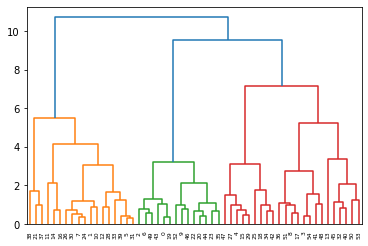

In [15]:
dendrogram(ward_clustering);

Согласимся с Python и выделим три кластера – три «ветки» наблюдений. Сохраним соответствующие метки кластеров в датафрейм:

In [16]:
cluster_labels = cut_tree(ward_clustering, n_clusters = 3).reshape(-1, )
df["cluster"] = cluster_labels
df.head()

,CSA2010,trees17,racdiv21,viol21,salepr19,cluster
0,Allendale/Irvington/S. Hilton,32.372913,24.604789,17.264634,77250.0,0
1,Beechfield/Ten Hills/West Hills,48.696974,52.412494,11.007200,149000.0,1
2,Belair-Edison,20.827125,23.826836,16.837918,89758.0,0
3,Brooklyn/Curtis Bay/Hawkins Point,14.631858,80.860745,18.028044,57000.0,2
4,Canton,12.516619,40.504514,6.796941,275000.0,2


**Дополнительно – для понимания кода выше.** Функция `cut_tree()` «разрезает» дендрограмму на желаемое число кластеров `n_clusters` (можно «разрезать» и по расстоянию `height`) и возвращает массив с метками кластеров такого вида:

In [17]:
# кластеры 0, 1, 2
cut_tree(ward_clustering, n_clusters = 3)

array([[0],
       [1],
       [0],
       [2],
       [2],
       [1],
       [0],
       [1],
       [2],
       [0],
       [1],
       [1],
       [1],
       [2],
       [1],
       [2],
       [1],
       [2],
       [2],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [2],
       [1],
       [2],
       [1],
       [2],
       [1],
       [1],
       [2],
       [1],
       [2],
       [0],
       [2],
       [1],
       [1],
       [1],
       [2],
       [2],
       [2],
       [0],
       [0],
       [2],
       [0],
       [2],
       [2],
       [0],
       [2],
       [2],
       [0],
       [2],
       [2]])

Вокруг каждой числовой метки есть лишние квадратные скобки. Чтобы от них избавиться, вызываем метод `.reshape()`, который позволяет перегруппировать массивы. В общем случае внутри `.reshape()` можно указывать два элемента размерности массива – число строк и столбцов:

In [18]:
# например, массив из 55 элементов сделали массивом размерности 5 на 11
# 5 строк (5 списков) и 11 столбцов (11 элементов в каждом списке)

cut_tree(ward_clustering, n_clusters = 3).reshape(5, 11)

array([[0, 1, 0, 2, 2, 1, 0, 1, 2, 0, 1],
       [1, 1, 2, 1, 2, 1, 2, 2, 0, 0, 1],
       [0, 0, 1, 2, 1, 2, 1, 2, 1, 1, 2],
       [1, 2, 0, 2, 1, 1, 1, 2, 2, 2, 0],
       [0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2]])

В изначальном массиве были лишние скобки вокруг «строк» – посмотрим на размерность:

In [19]:
cut_tree(ward_clustering, n_clusters = 3).shape

(55, 1)

Число 1 здесь можно интерпретировать как число списков в каждой строке. Мы хотим от этих списков избавиться, чтобы получить обычный перечень значений, поэтому в `.reshape()` указываем значение `-1`. В итоге получается массив размерности 55 на 0, что в рамках NumPy соответствует одномерным массивам, похожим на обычные списки в Python:

In [20]:
cut_tree(ward_clustering, n_clusters = 3).reshape(-1, ).shape

(55,)

In [21]:
# внутри array() – просто список без лишних скобок вокруг элементов

cut_tree(ward_clustering, n_clusters = 3).reshape(-1, )

array([0, 1, 0, 2, 2, 1, 0, 1, 2, 0, 1, 1, 1, 2, 1, 2, 1, 2, 2, 0, 0, 1,
       0, 0, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 0, 2, 1, 1, 1, 2, 2, 2, 0,
       0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2])

Вернёмся к полученным кластерам, чьи названия мы сохранили в столбец `cluster`. Посмотрим, сколько наблюдений в каждом кластере:

In [22]:
df["cluster"].value_counts()

2    23
1    18
0    14
Name: cluster, dtype: int64

Кластер с индексом 2 – самый большой, с индексом 0 – самый маленький. Но при этом число наблюдений в каждом кластере не супер-маленькое, явных оснований для укрупнений (или для отдельного изучения этих «микрокластеров» нет). 

Посмотрим на средние по группам:

In [23]:
# в .groupby() указываем основание для группировки
# в .agg() указываем функцию для нужной статистики
# numeric_only – считаем средние только для числовых столбцов

df.groupby("cluster").agg("mean", numeric_only = True)

,trees17,racdiv21,viol21,salepr19
cluster,,,,
0,22.315360,19.028795,23.834908,74542.571429
1,43.819606,40.324361,8.718892,186504.166667
2,13.704457,57.566573,20.965829,169584.673913


Итак, средние значения показателей в трёх группах, чисто визуально, различаются, причём в большинстве случаев довольно существенно. Для наглядности давайте перейдём к визуализации распределений по группам и построим ящики с усами.

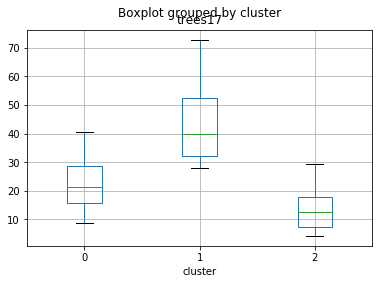

In [24]:
df.boxplot(column = "trees17", by = "cluster");

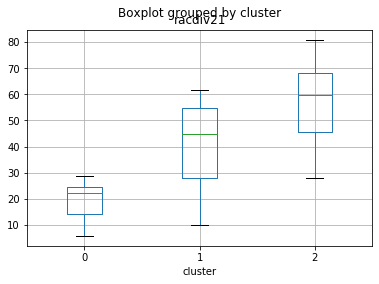

In [25]:
df.boxplot(column = "racdiv21", by = "cluster");

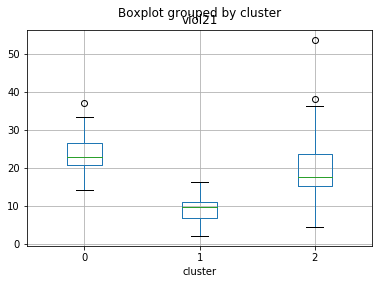

In [26]:
df.boxplot(column = "viol21", by = "cluster");

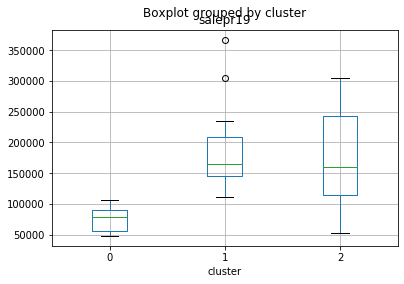

In [33]:
df.boxplot(column = "salepr19", by = "cluster");

Обобщая все полученные графики, заметим следующее:
    
* кластер 0: однозначно не самые благополучные районы с довольно высокой преступностью, не очень зелёные, с низким расовым/этническим разнообразием, жильё очень дешёвое; возможно, промышленные «рабочие» районы или «проблемные» районы (индустриализация/деиндустриализация, проблемы с застройкой, переселением, ценами на жилье, там много факторов даже исторически);

* кластер 1: однозначно благополучные районы с низким уровнем преступности, самые зелёные, жильё не самое дорогое (хотя есть районы с нетипично дорогим жильём – выбросы); возможно, приятные районы на окраинах/на берегу;

* кластер 2: не самый однозначный кластер, самые «незелёные» районы с очень разными значениями уровня преступности и ценами на жильё, при этом с высоким уровнем расового/этнического разнообразия; возможно, центральные и нецентральные бизнес-районы с большим числом рабочих мест.

Для более формального сравнения групп можно обратиться к статистическим критериям, но о них мы будем говорить позже, поэтому пока остановимся на этапе разведывательного анализа и визуализации.

### Часть 3: кластеры и география

Установим и импортируем библиотеку `geopandas`, это надстройка над `pandas`, которая позволяет загружать файлы с географической информацией (в частности, файлы `.geojson`) и отрисовывать карты. 

In [ ]:
# раскомментируйте строку ниже для установки
!pip install geopandas

In [27]:
import geopandas

В файле `Percent_of_Area_Covered_by_Trees.geojson` хранится информация о проценте деревьев в районах и вспомогательная географическая информация о каждом районе – набор точек для определения и отрисовки границ района. 

При загрузке geojson-файла через функцию `read_file()` данные внешне ничем не отличаются от обычного датафрейма `pandas`:

In [28]:
gdf = geopandas.read_file("Percent_of_Area_Covered_by_Trees.geojson")
gdf.head()

,OBJECTID,CSA2010,trees11,trees17,Shape__Area,Shape__Length,geometry
0,1,Allendale/Irvington/S. Hilton,32.871637,32.372913,6.377046e+07,38770.165571,"POLYGON ((-76.65726 39.27600, -76.65726 39.276..."
1,2,Beechfield/Ten Hills/West Hills,48.825457,48.696974,4.788253e+07,37524.950533,"POLYGON ((-76.69479 39.30201, -76.69465 39.301..."
2,3,Belair-Edison,20.358073,20.827125,4.495003e+07,31307.314843,"POLYGON ((-76.56761 39.32636, -76.56746 39.326..."
3,4,Brooklyn/Curtis Bay/Hawkins Point,14.459935,14.631858,1.760777e+08,150987.703639,"MULTIPOLYGON (((-76.58867 39.21283, -76.58824 ..."
4,5,Canton,10.232515,12.516619,1.540854e+07,23338.611948,"POLYGON ((-76.57140 39.28441, -76.57138 39.284..."


Каждый район – это отдельный объект на карте. Чисто геометрически, этот объект – многоугольник, то есть какая-то область, ограниченная замкнутой ломаной линией, *polygon* на английском языке. Поэтому здесь в таблице в столбце `geometry` хранятся объекты специального типа *POLYGON*, которые внутри похожи на кортежи с парными координатами точек (широта и долгота) в выбранной географической проекции. По этим точкам район отрисовывается на карте. В столбце `geometry` также есть объекты типа *MULTIPOLYGON* для больших районов или районов со сложными границами, которые удобнее собрать из нескольких многоугольников. Столбец `Shape__Area` – это площадь района на карте, площадь многоугольника, а столбец `Shape__Length` – его периметр, длина ограничивающей замкнутой линии. 

К такому более продвинутому датафрейму типа *GeoDataFrame* можно применить метод `.plot()` и построить карту!

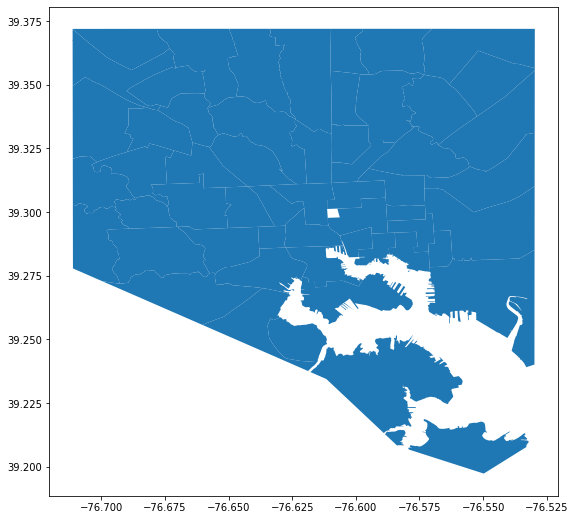

In [29]:
# выставляем размер 16 на 9 дюймов – побольше

gdf.plot(figsize = (16, 9));

Если на вход методу `.plot()` мы ещё подадим столбец с какими-то текстовыми или числовыми метками, произойдёт автоматическая раскраска карты:

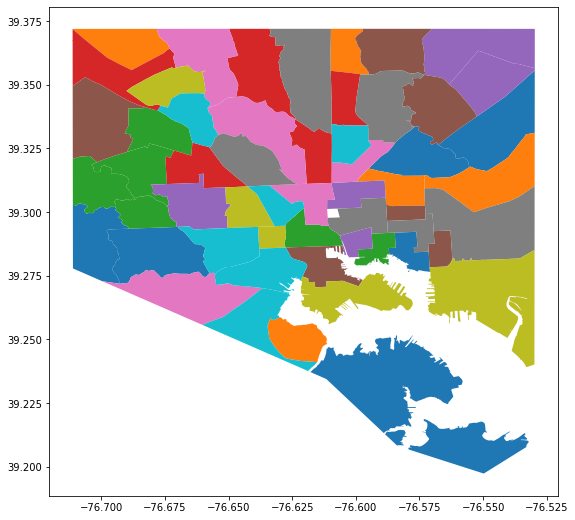

In [30]:
gdf.plot("CSA2010", figsize = (16, 9));

Вообще каждому уникальному значению `CSA2010`, то есть каждому району, должен соответствовать уникальный цвет, но поскольку таких больших готовых палитр на 55 цветов не существует, с какого-то момента Python начинает использовать те же цвета. 

Добавим в `gdf` столбец с метками наших кластеров:

In [31]:
gdf["cluster"] = df["cluster"]

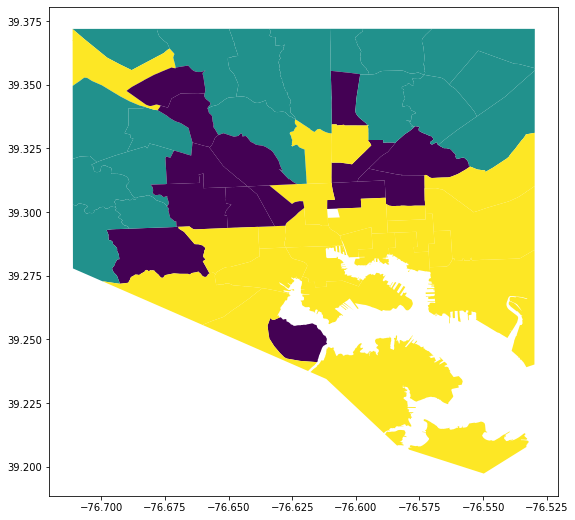

In [32]:
gdf.plot("cluster", figsize = (16, 9));

Выглядит получше, но не совсем с ходу понятно, где какой кластер. Давайте создадим копию столбца с метками кластеров, назовём его `color`, а затем в виде словаря опишем пары соответствий – какие значения на какой цвет поменять:

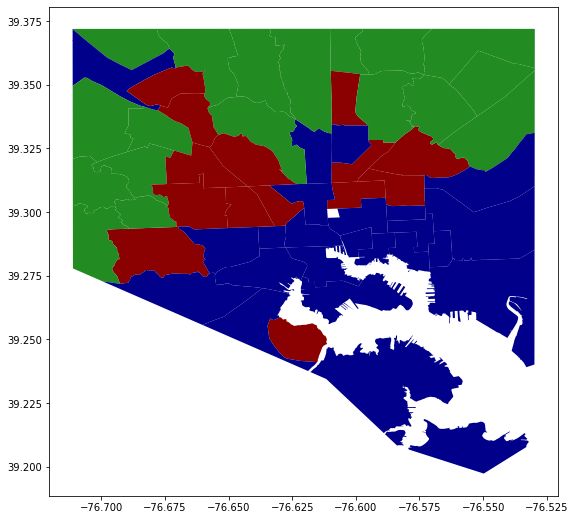

In [34]:
# создаем копию столбца
gdf["color"] = gdf["cluster"]

# словарь для перевода метки в цвета
convert = {0 : "darkred", 1: "forestgreen", 2 : "darkblue"}

# замена по правилу, описанном в словаре 
gdf = gdf.replace({"color" : convert})

# раз свои цвета – не просто color, а color = gdf["color"]
gdf.plot(color = gdf["color"], figsize = (16, 9));

Итого: 

* кластер 1 (темно-зелёный цвет) с самыми зелёными районами – северная часть города;
* кластер 0 (тёмно-красный цвет) с не самыми благополучными районами – «непарадная» часть города, не центр и не районы вокруг Внутренней Гавани;
* кластер 2 (тёмно-синий цвет) с благополучными незелёными районами – преимущественно «парадная» часть города, исторический и деловой центр, районы с развитой инфраструктурой и проч.

P.S. Глядя на карту, возникает вопрос: а что это за таинственный белый квадрат в середине карты? Обычно такое возникает либо в случае, когда данных нет (даже географическая информация по району отсутствует), либо когда на данном месте находится что-то незаселённое (водоём, например). Можете провести самостоятельное расследование ([онлайн-карта](https://data.baltimorecity.gov/maps/e8b7beca0fd649b1a77c58fafc4658a9/about) по тому же исходнику вам в помощь)!

### Бонус: градиентная раскраска карты

На месте показателя, который используется для раскрашивания районов, может быть и «полноценный» числовой столбец, как с целыми, так и дробными значениями, тогда раскраска карты будет производиться с помощью градиентной палитры, а не фиксированного набора цветов:

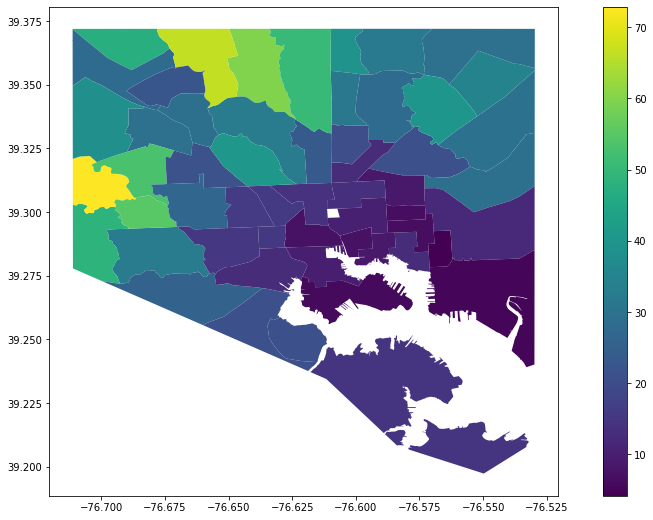

In [35]:
# включаем легенду для ясности

gdf.plot("trees17", figsize = (16, 9), legend = True);

Python по-прежнему использует палитру `viridis`, встроенную по умолчанию, которая предполагает градиентную растяжку цветов от фиолетового до желтого через синий и зеленый. В данном случае такой выбор палитры не совсем удачен, поскольку районы с самым высоким значением показателя оказались самыми светлыми, а с самым низким – темными. Эта палитра хорошо подошла бы для показателя с отрицательными и положительными значениями: районы с отрицательными значениями получались бы в сине-фиолетовой гамме, а с положительными – в желто-зеленой. Изменим палитру на более логичную для данного случая:

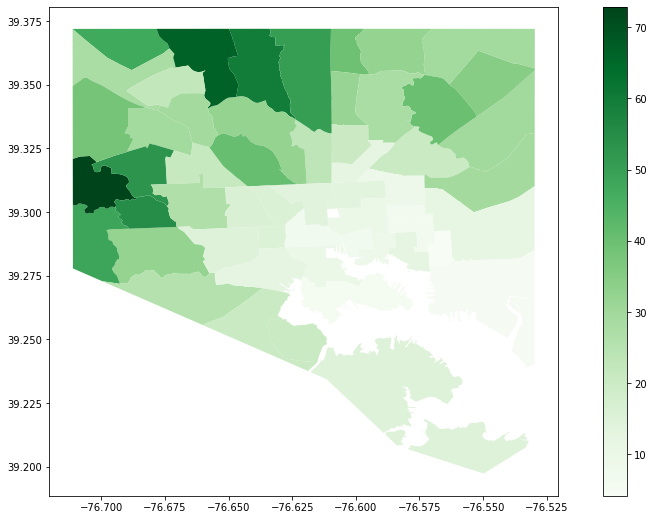

In [43]:
# аргумент cmap, от color map

gdf.plot("trees17", figsize = (16, 9), legend = True, cmap = "Greens");

Перечень доступных палитр можно посмотреть [здесь](https://matplotlib.org/stable/users/explain/colors/colormaps.html) (он единый для всех графиков, не только для карт).